# Transforming data to CSV files (replacing comma by semicolon)

In [1]:
import os
import pandas as pd
import torch

# Constants of the data-file format
DATA_FILE_EXT = '.csv'
data_version_dir = "v3.0"

in_data_dir = f"y:/datasets/dyslex/experiment-final/{data_version_dir}/original/"
out_data_dir = f"y:/datasets/dyslex/experiment-final/{data_version_dir}/original-csv/"

out_data_extracted_features_dir = f"y:/datasets/dyslex/experiment-final/{data_version_dir}/extracted_features/"
out_data_fixation_images_dir = f"y:/datasets/dyslex/experiment-final/{data_version_dir}/fixation_images/"
out_models_dir = f"y:/trials/xsedmid/dyslex/experiment-final/{data_version_dir}/models/"
out_results_dir = f"y:/trials/xsedmid/dyslex/experiment-final/{data_version_dir}/results/"

fill_null_values_by_zero = True
summarize_characteristics_by_mean = True
#summarize_characteristics_by_mean = False
normalize_values = False
#normalize_values = True
regenerate_fixation_images = True
#regenerate_fixation_images = False
generate_fixation_image_for_each_trialid = False
train_models_MLP = True
train_models_CNN = True
retrain_models = True

data_files = os.listdir(in_data_dir)
data_files = list(filter(lambda f: f.lower().endswith(DATA_FILE_EXT.lower()), data_files))
print('File count: {}'.format(len(data_files)))

# Convert input csv-like files from comma to semicolon separated values
if False:
    print('Converting files from comma to semicolon separated values')
    for f in data_files:
        
        # Replace comma with semicolon in each file
        df = pd.read_csv(os.path.join(in_data_dir, f), skiprows=0, sep=',')
        print(f)
        df.to_csv(os.path.join(out_data_dir, f), sep=';', index=False)

File count: 1470


# Parsing .CSV files and transforming task-related features into internal representations

In [2]:
import feature_extractor as feat_ext
import json
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
import os

# Read task-invariant properties from a json file
with open('properties.json') as property_file:
    properties = json.loads(property_file.read())

# Path to directory with metainformation about the dataset and features for individual tasks
meta_dir = properties['meta_dir']

aoi_id_col_name = properties['aoi_id_col_name']
subject_id_col_name = properties['subject_id_col_name']
degrees_visual_angle_pixels = properties['degrees_visual_angle_pixels']

# Fixation image parameters
fixation_image_characteristics_names = [
    properties['fixation_image_fix_x_col_name'],
    properties['fixation_image_fix_y_col_name'],
    properties['fixation_image_disp_x_col_name'],
    properties['fixation_image_disp_y_col_name'],
    properties['fixation_image_duration_ms_col_name']
    ]
fixation_image_visual_params = eval(properties['fixation_image_visual_params'])

# Task definitions
tasks_def = eval(properties['tasks'])
task_feature_def_dict = feat_ext.load_task_feature_definition_dict(tasks_def, meta_dir)
task_definitions = [(task['type_id'], task['desc'], task['id']) for task in tasks_def]

for task_type_id, task_desc, task_id in task_definitions:
    data_dict = {}

    ###############################################################################################################
    # Global characteristics
    ###############################################################################################################
    # Read the metric data files for the task
    subject_metrics_files = os.listdir(in_data_dir)
    subject_metrics_files = list(filter(lambda file_name: file_name.lower().endswith(('_' + task_id + '_metrics' + DATA_FILE_EXT).lower()), subject_metrics_files))
    print('* file count: {}'.format(len(subject_metrics_files)))

    for file_name in subject_metrics_files:
        subject_id, subject_data_dict = feat_ext.load_and_transform_subject_characteristics(task_type_id, task_feature_def_dict, fill_null_values_by_zero, subject_id_col_name, aoi_id_col_name, summarize_characteristics_by_mean, os.path.join(in_data_dir, file_name))
        data_dict[subject_id] = subject_data_dict
    
    print(f'* subject count: {len(data_dict)}')

    # Normalize the dictionary data independently for each type of characteristics
    if normalize_values:
        for (characteristics_name, columns) in [('characteristics_global', task_feature_def_dict[task_type_id]['characteristics_global']), ('characteristics', task_feature_def_dict[task_type_id]['characteristics']), ('AOIs_characteristics', task_feature_def_dict[task_type_id]['aoi_characteristics'])]:
            if (columns is not None):
                print(f'* normalization-{characteristics_name}:')
                #for column in columns:
                for column in data_dict[subject_id][characteristics_name].columns:
                    
                    # Get the values of the characteristic for all subjects
                    all_characteristics_values = [data_dict[subject_id][characteristics_name][column].values for subject_id in data_dict.keys()]
                    # Flatten the list of values
                    all_characteristics_values = [value for sublist in all_characteristics_values for value in sublist]
                    # Get the mean and standard deviation of the values
                    mean = np.mean(all_characteristics_values)
                    std = np.std(all_characteristics_values)
                    # Normalize the values for each subject
                    for subject_id in data_dict.keys():
                        data_dict[subject_id][characteristics_name].loc[:, column] = data_dict[subject_id][characteristics_name][column].apply(lambda x: (x - mean) / std)
                    print(f'  - {column}:{len(all_characteristics_values)}: {mean} +/- {std}')

    # Flatten the dictionary data
    df_fixations_all = []
    for subject_id in data_dict.keys():
        df_fixations_all.append(feat_ext.create_subject_characteristics_profile(subject_id, data_dict[subject_id]))
    df_fixations_all = pd.concat(df_fixations_all, axis=0)
    print(f'final df: {df_fixations_all.shape}')
    out_file_name = os.path.join(out_data_extracted_features_dir, task_type_id + '_' + task_desc + '_features' + DATA_FILE_EXT)
    df_fixations_all.to_csv(out_file_name, sep=';', index=False)
    
    ###############################################################################################################
    # Fixation images
    ###############################################################################################################
    if regenerate_fixation_images:
        print(f'* generating fixation images...')
        subject_fixations_files = os.listdir(in_data_dir)
        subject_fixations_files = list(filter(lambda file_name: file_name.lower().endswith(('_' + task_type_id + '_' + task_desc + '_fixations' + DATA_FILE_EXT).lower()), subject_fixations_files))
        
        # Task-related fixation image visual parameters
        x_min, x_max, y_min, y_max, d_max = fixation_image_visual_params[task_type_id]
        fixation_duration_color_norm = Normalize(0, d_max)

        df_fixations_all = []
        for file_name in subject_fixations_files:

            subject_fixations_file_path = os.path.join(in_data_dir, file_name)
            subject_id, figs_dict, df_subject_fixations = feat_ext.generate_subject_fixation_images(generate_fixation_image_for_each_trialid, fixation_image_characteristics_names, fill_null_values_by_zero, subject_id_col_name, degrees_visual_angle_pixels, fixation_duration_color_norm, x_min, x_max, y_min, y_max, subject_fixations_file_path)
            
            for df in df_subject_fixations:
                df_fixations_all.append(df)

            # Saves the fixation images
            for trial_id in figs_dict.keys():
                feat_ext.save_fixation_image(figs_dict[trial_id], out_data_fixation_images_dir, task_id, subject_id, trial_id)

        # Print the minimum and maximum values of individual task-related fixation features
        df_fixations_all = pd.concat(df_fixations_all, axis=0)
        for column in df_fixations_all.columns:
            print(f'  - {column}: min={df_fixations_all[column].min():.2f}; max={df_fixations_all[column].max():.2f}')


* AOI characteristics: 5, AOIs: 90
* characteristics-global: 2
* characteristics: 3, expected line count: 60
* characteristics-global: 3
* characteristics: 2, expected line count: 60
* characteristics-global: 6
* AOI characteristics: 4, AOIs: 7
* characteristics-global: 6
* AOI characteristics: 4, AOIs: 7
* AOI characteristics: 5, AOIs: 55
* AOI characteristics: 5, AOIs: 55
* file count: 70
* subject count: 70
final df: (70, 451)
* generating fixation images...
  - fix_x: min=100.68; max=1653.63
  - fix_y: min=160.50; max=841.50
  - disp_x: min=0.00; max=5.91
  - disp_y: min=0.00; max=6.06
  - duration_ms: min=40.00; max=6943.69
* file count: 70
* subject count: 70
final df: (70, 6)
* generating fixation images...
  - fix_x: min=-154.26; max=1836.30
  - fix_y: min=-17.48; max=1136.64
  - disp_x: min=0.01; max=25.79
  - disp_y: min=0.00; max=12.84
  - duration_ms: min=11.98; max=1008.07
* file count: 70
* subject count: 70
final df: (70, 6)
* generating fixation images...
  - fix_x: min

# Evaluation

In [3]:
from models import MLP, binary_resnet18, binary_resnet50
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from typing import Dict
from utils import cross_validate_sklearn
from utils import cross_validate_pytorch
from utils import build_global_statistics_data_loader, build_fixation_visualisation_data_loader, create_image_folder_dataset, get_cross_validate_pytorch_model_path

torch.set_default_dtype(torch.float64)

class_count = 2
training_param_cv_split_count = 5

# training_param_kNN_k_values = [3]
training_param_kNN_k_values = [1, 3, 4, 5, 10]

training_param_MLP_layer_feature_size_decrease = 2
#training_param_MLP_layer_count_values = [2]
training_param_MLP_layer_count_values = [1, 2]
#training_param_MLP_drop_values = [0.2, 0.5]
training_param_MLP_drop_values = [0.0, 0.2, 0.5]
training_param_MLP_epoch_count_values = [10, 20]
training_param_MLP_lr_values = [0.1, 0.05]

#training_param_CNN_epoch_count_values = [20, 50]
training_param_CNN_epoch_count_values = [100]
training_param_CNN_lr_values = [0.001, 0.0001, 0.00001]

cross_validation = RepeatedStratifiedKFold(n_splits=training_param_cv_split_count, n_repeats=1, random_state=42)

# Read a class_id-class_label dictionary from a csv file
df_class_labels = pd.read_csv(os.path.join(meta_dir, 'class_ids.txt'), skiprows=0, sep=',')

# Read the names of characteristics-global if the file exists
subject_class_mapping = pd.read_csv(os.path.join(meta_dir, 'subject_class_mapping-' + data_version_dir + '.txt'), skiprows=0, sep=',')

task_data : Dict[str, pd.DataFrame] = {}
for task_type_id, task_desc, task_id in task_definitions:
    print('#' * 80)
    print(f'Processing task: {task_type_id} ({task_desc})')

    task_data_file_name = os.path.join(out_data_extracted_features_dir, task_id + '_features' + DATA_FILE_EXT)
    task_data[task_type_id] = pd.read_csv(task_data_file_name, skiprows=0, sep=';')#, dtype=np.float64
    
    # Join the data with the subject class mapping
    task_subject_class_mapping = task_data[task_type_id].merge(subject_class_mapping, on='subject_id', how='left')[['subject_id', 'class_id']]

    df_subject_ids = task_data[task_type_id]['subject_id']
    X = task_data[task_type_id].drop('subject_id', axis=1).astype(np.float64)
    y = task_subject_class_mapping['class_id']
        
    # Get the feature count
    print(f'Feature count: {len(X.columns)}')
    n_features = len(X.columns)

    ###############################################################################################################
    # kNN
    ###############################################################################################################

    # kNN with default parameters (p=2, metric='minkowski') results in the Euclidean distance comparison
    for training_param_kNN_k in training_param_kNN_k_values:
        # kNN with all objects (i.e., no cross-validation) and standard (not-balanced) accuracy
        exp_id = f'{task_type_id}_{task_desc}_{training_param_kNN_k}NN'
        knn = KNeighborsClassifier(n_neighbors=training_param_kNN_k)
        knn.fit(X, np.asarray(y.values))
        X_preds = knn.predict(X)
        print(f'{training_param_kNN_k}NN-all-!BA : {accuracy_score(y.values, X_preds):.4f}')
        #print(f'acc.: {torch.sum(torch.tensor(X_preds) == torch.tensor(y.values)) / len(X_preds)}')

        # # kNN with cross-validation -- an alternative implementation for verification
        # scores = cross_val_score(
        #     knn,
        #     X,
        #     y=np.asarray(y.values),
        #     scoring = 'balanced_accuracy',
        #     cv=cross_validation,
        # )
        # print(f'{training_param_kNN_k}NN         : {scores.mean():.4f} +/- {scores.std():.4f}')

        # kNN without the scaler
        scores = cross_validate_sklearn(
            exp_id + '_without_scaler',
            out_models_dir,
            out_results_dir,
            lambda: KNeighborsClassifier(n_neighbors=training_param_kNN_k),
            X,
            np.asarray(y),
            df_subject_ids,
            df_class_labels,
            cross_validation,
            use_scaler=False
        )
        print(f'{training_param_kNN_k}NN no scaler: {scores.mean():.4f} +/- {scores.std():.4f}')

        # kNN with the scaler
        scores = cross_validate_sklearn(
            exp_id + '_with_scaler',
            out_models_dir,
            out_results_dir,
            lambda: KNeighborsClassifier(n_neighbors=training_param_kNN_k),
            X,
            np.asarray(y),
            df_subject_ids,
            df_class_labels,
            cross_validation,
            use_scaler=True
        )
        print(f'{training_param_kNN_k}NN scaler  : {scores.mean():.4f} +/- {scores.std():.4f}')

    ###############################################################################################################
    # MLP
    ###############################################################################################################

    if train_models_MLP:
        for training_param_MLP_layer_count in training_param_MLP_layer_count_values:
            for training_param_MLP_drop in training_param_MLP_drop_values:
                for training_param_epoch_count in training_param_MLP_epoch_count_values:
                    for training_param_lr in training_param_MLP_lr_values:
                        exp_id = f'{task_type_id}_{task_desc}_MLP_lc{training_param_MLP_layer_count}_lf{training_param_MLP_layer_feature_size_decrease}_d{training_param_MLP_drop}'
                        if retrain_models or (not os.path.exists(get_cross_validate_pytorch_model_path(out_models_dir, exp_id, training_param_epoch_count, training_param_lr))):
                            scores, cv_score_best = cross_validate_pytorch(
                                exp_id,
                                out_models_dir,
                                out_results_dir,
                                lambda: MLP(n_features, n_features // training_param_MLP_layer_feature_size_decrease, class_count, training_param_MLP_layer_count, training_param_MLP_drop),
                                training_param_epoch_count,
                                training_param_lr,
                                X,
                                np.asarray(y),
                                df_subject_ids,
                                df_class_labels,
                                build_global_statistics_data_loader,
                                cross_validation,
                                train_classifier=True
                            )
                            print(f'MLP-lc{training_param_MLP_layer_count}-d{training_param_MLP_drop}-e{training_param_epoch_count}_lr{training_param_lr}         : {scores.mean():.4f} +/- {scores.std():.4f} (best epoch: {cv_score_best:.4f})')

    ###############################################################################################################
    # Fixation images
    ###############################################################################################################
    image_dir = os.path.join(out_data_fixation_images_dir, task_type_id + '_' + task_desc)
    image_filenames = [filename for filename in os.listdir(image_dir) if any(filename.lower().endswith(ext) for ext in '.png')]
    image_paths = [os.path.join(image_dir, filename) for filename in image_filenames]
    image_subject_ids = [int(filename.split('_')[0]) for filename in image_filenames]
    
    df_image_subject_class_ids = pd.DataFrame({'subject_id': image_subject_ids}).merge(subject_class_mapping, on='subject_id', how='left')[['subject_id', 'class_id']]
    df_image_subject_ids = df_image_subject_class_ids['subject_id']
    df_image_class_ids = df_image_subject_class_ids['class_id']
    
    image_dataset = create_image_folder_dataset(image_paths, df_image_class_ids.values)

    ###############################################################################################################
    # CNNs
    ###############################################################################################################
    if train_models_CNN:
        for training_param_epoch_count in training_param_CNN_epoch_count_values:
            for training_param_lr in training_param_CNN_lr_values:

                exp_id = f'{task_type_id}_{task_desc}_ResNet18'
                if retrain_models or (not os.path.exists(get_cross_validate_pytorch_model_path(out_models_dir, exp_id, training_param_epoch_count, training_param_lr))):
                    scores, cv_score_best = cross_validate_pytorch(
                        exp_id,
                        out_models_dir,
                        out_results_dir,
                        binary_resnet18,
                        training_param_epoch_count,
                        training_param_lr,
                        image_paths,
                        np.asarray(df_image_class_ids.values),
                        df_image_subject_ids,
                        df_class_labels,
                        build_fixation_visualisation_data_loader,
                        cross_validation,
                        train_classifier=True,
                        dataset=image_dataset
                    )
                    print(f'ResNet18-e{training_param_epoch_count}_lr{training_param_lr}    : {scores.mean():.4f} +/- {scores.std():.4f} (best epoch: {cv_score_best:.4f})')

                exp_id = f'{task_type_id}_{task_desc}_ResNet50'
                if retrain_models or (not os.path.exists(get_cross_validate_pytorch_model_path(out_models_dir, exp_id, training_param_epoch_count, training_param_lr))):
                    scores, cv_score_best = cross_validate_pytorch(
                        exp_id,
                        out_models_dir,
                        out_results_dir,
                        binary_resnet50,
                        training_param_epoch_count,
                        training_param_lr,
                        image_paths,
                        np.asarray(df_image_class_ids.values),
                        df_image_subject_ids,
                        df_class_labels,
                        build_fixation_visualisation_data_loader,
                        cross_validation,
                        train_classifier=True,
                        dataset=image_dataset
                    )
                    print(f'ResNet50-e{training_param_epoch_count}_lr{training_param_lr}    : {scores.mean():.4f} +/- {scores.std():.4f} (best epoch: {cv_score_best:.4f})')


################################################################################
Processing task: T1 (Syllables)
Feature count: 450
1NN-all-!BA : 1.0000
1NN no scaler: 0.7429 +/- 0.0571
1NN scaler  : 0.6857 +/- 0.0728
3NN-all-!BA : 0.8000
3NN no scaler: 0.7429 +/- 0.0571
3NN scaler  : 0.6571 +/- 0.0833
4NN-all-!BA : 0.7571
4NN no scaler: 0.6571 +/- 0.0535
4NN scaler  : 0.5857 +/- 0.0286
5NN-all-!BA : 0.8143
5NN no scaler: 0.6714 +/- 0.0571
5NN scaler  : 0.6857 +/- 0.0350
10NN-all-!BA : 0.6857
10NN no scaler: 0.6571 +/- 0.0535
10NN scaler  : 0.5857 +/- 0.0286
MLP-lc1-d0.0-e10_lr0.1         : 0.8571 +/- 0.0904 (best epoch: 1.0000)
MLP-lc1-d0.0-e10_lr0.05         : 0.8571 +/- 0.0904 (best epoch: 1.0000)
MLP-lc1-d0.0-e20_lr0.1         : 0.8429 +/- 0.0535 (best epoch: 0.9286)
MLP-lc1-d0.0-e20_lr0.05         : 0.8571 +/- 0.0639 (best epoch: 0.9286)
MLP-lc1-d0.2-e10_lr0.1         : 0.8571 +/- 0.0904 (best epoch: 1.0000)
MLP-lc1-d0.2-e10_lr0.05         : 0.8571 +/- 0.0904 (best epoch: 1.0000)


# Plots

T1_Syllables_10NN_without_scaler.csv: 0.6571 +/- 0.0535 (predicted classes: [0 1]; counts: [59 11])
T1_Syllables_10NN_with_scaler.csv: 0.5857 +/- 0.0286 (predicted classes: [0 1]; counts: [64  6])
T1_Syllables_1NN_without_scaler.csv: 0.7429 +/- 0.0571 (predicted classes: [0 1]; counts: [51 19])
T1_Syllables_1NN_with_scaler.csv: 0.6857 +/- 0.0728 (predicted classes: [0 1]; counts: [55 15])
T1_Syllables_3NN_without_scaler.csv: 0.7429 +/- 0.0571 (predicted classes: [0 1]; counts: [53 17])
T1_Syllables_3NN_with_scaler.csv: 0.6571 +/- 0.0833 (predicted classes: [0 1]; counts: [57 13])
T1_Syllables_4NN_without_scaler.csv: 0.6571 +/- 0.0535 (predicted classes: [0 1]; counts: [59 11])
T1_Syllables_4NN_with_scaler.csv: 0.5857 +/- 0.0286 (predicted classes: [0 1]; counts: [64  6])
T1_Syllables_5NN_without_scaler.csv: 0.6714 +/- 0.0571 (predicted classes: [0 1]; counts: [56 14])
T1_Syllables_5NN_with_scaler.csv: 0.6857 +/- 0.0350 (predicted classes: [0 1]; counts: [57 13])
T1_Syllables_MLP_lc1_lf

Text(0, 0.5, 'Balanced accuracy (%)')

c:\Users\xsedmid.NTFI\AppData\Local\Programs\Python\virtual_envs\venv-Python3.11\Lib\site-packages\IPython\core\events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
c:\Users\xsedmid.NTFI\AppData\Local\Programs\Python\virtual_envs\venv-Python3.11\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


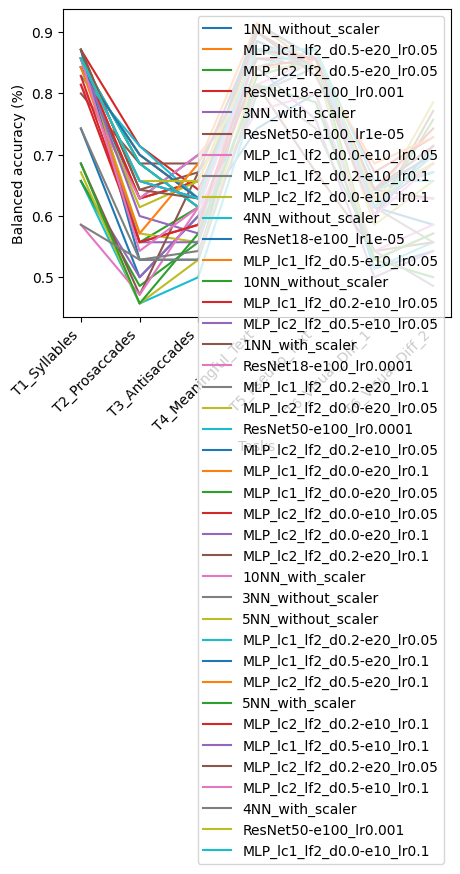

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score

plot_dict: Dict = {}
approach_names = []
for task_type_id, task_desc, task_id in task_definitions:
    task_file_prefix = task_id + '_'

    results_files = os.listdir(out_results_dir)
    results_files = list(filter(lambda f: f.lower().startswith(task_file_prefix.lower()) and f.lower().endswith(DATA_FILE_EXT.lower()), results_files))
    for result_file in results_files:

        # Get the approach name from the file name
        approach_name = result_file[len(task_file_prefix):-len(DATA_FILE_EXT)]
        approach_names.append(approach_name)

        df = pd.read_csv(os.path.join(out_results_dir, result_file), skiprows=0, sep=',')

        # Convert column values to a numpy array
        targets = np.asarray(df['subject_class_id'].values)
        preds = np.asarray(df['pred_class_id'].values)
        
        # Compute the number of different values and their counts in targets and preds
        target_values, target_values_counts = np.unique(targets, return_counts=True)
        pred_values, pred_values_counts = np.unique(preds, return_counts=True)

        # Split targets and predictions into batches of a fixed size
        batch_size = targets.size / training_param_cv_split_count
        targets_batches = np.array_split(targets, len(targets) // batch_size)
        preds_batches = np.array_split(preds, len(preds) // batch_size)

        # Calculate the balanced accuracy score for each batch
        scores = []
        for i, (target_batch, pred_batch) in enumerate(zip(targets_batches, preds_batches)):
            scores.append(balanced_accuracy_score(target_batch, pred_batch))
        # Print the mean and standard deviation of the balanced accuracy scores
        print(f'{result_file}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} (predicted classes: {pred_values}; counts: {pred_values_counts})')
        
        # Add the score to the plot dictionary
        plot_dict[(task_id, approach_name)] = np.mean(scores)

# Make the approach names unique
approach_names = list(set(approach_names))

#df_plot = pd.DataFrame()
fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')

# Get numpy array from task ids
task_ids_np = np.array([task_id for task_type_id, task_desc, task_id in task_definitions])

# Generate the plot for each approach
for approach_name in approach_names:
    scores = []
    for task_type_id, task_desc, task_id in task_definitions:
        scores.append(plot_dict[(task_id, approach_name)] if (task_id, approach_name) in plot_dict else 0)
    #ax.scatter(task_ids_np, scores, s=100, alpha=0.5, label=approach_name)
    ax.plot(task_ids_np, scores, label=approach_name)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

ax.legend()
ax.set_xlabel('Tasks')
ax.set_ylabel('Balanced accuracy (%)')
